In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 256  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 150       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.rnn = nn.RNNCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.rnn(input, hidden)
        output = self.linear(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): RNNCell(100, 150)
  (linear): Linear(in_features=150, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
# NOTE: You may reduce the number of training iterations if the training takes long.
iters       = 20000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.002)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss.item()                             # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/20000 loss:3.3557787942886352
generated sequence: W}d,ilh K tiapl mt the t
,u, v]

:wetf. ni ro ro
 ; dsthWhmiheiate, r m Thoc
eano,ell te ulr nhmnevch

iter:199/20000 loss:2.9598396396636963
generated sequence: W[wlt.

op'sc in pore,o
ided Wpf u.stSaan 
EaPeich.,,
Y
Whenl 
her ealyes aine
aS tglisn doounhireyn


iter:299/20000 loss:2.575741984844208
generated sequence: Wa+ghipf yitd
Ta thit:
Thethin nom ders,,
Ant mort tet, th the ther
gf matsvere, sonsind the th thotc

iter:399/20000 loss:2.424455029964447
generated sequence: Werd at meele feeandt risif thet: un;
Tem
beply reare-bagrneanh phe hivesh we Panme, son kedestmrresu

iter:499/20000 loss:2.3321819734573364
generated sequence: WYytt with mint'n,
Thaw outhy their aplaldseve nulther aris, ravenasend an ie mand thes emesam ;her; 

iter:599/20000 loss:2.284963128566742
generated sequence: Why he satt vass houd on t it my will the hivyXexthem. shem'she pway an iody you
H:
Arp Wombthels wat

iter:699/20000 loss:2.2463564217

iter:5199/20000 loss:1.8011454916000367
generated sequence: Wecken and stanby:
Comel, a desease;
He the beity and then retery stafily and a wands, pars
A from
yo

iter:5299/20000 loss:1.7739386177062988
generated sequence: With beg.
Of, should, to bege, spangodiretmees;
For feak lepart of speak neeses of hory onee go.

BAN

iter:5399/20000 loss:1.7641001915931702
generated sequence: Wech,
She such.

CORINANG RO:
O: than king birn! ife deling itcem to the owait, anord's a worth.

DUK

iter:5499/20000 loss:1.7639698481559754
generated sequence: WAsh you ur hene this calt desance,
Was done: I say which is nays' boring, as the rogech: tite my to 

iter:5599/20000 loss:1.7532490813732147
generated sequence: Welwow:
Now Lat she hen, indwect though ead This deegh, worw, and betrun had the morr'd upornage time

iter:5699/20000 loss:1.77092151761055
generated sequence: WARWARANUS:
Ah! would leeve that come,
Ind's so do your forty not reverrustide,
Yorr daick,
You mouth

iter:5799/20000 loss:1.7

iter:10299/20000 loss:1.6957967758178711
generated sequence: Waciof cins be noblong: and laid is my love: do not houst, is enerence is con Edward
If come bodacing

iter:10399/20000 loss:1.6829121458530425
generated sequence: Will comes;
His truing ond alldues and the Vall followe'd will sid?

GRUMIO:
Come the orreyt? at Sign

iter:10499/20000 loss:1.6863238096237183
generated sequence: Wibowe mis
and fear
That you the trimigerms, dut of to camping shemittes paithice so do dareb
thou ni

iter:10599/20000 loss:1.6734517753124236
generated sequence: WERLANUS:
What's too'takion, that hand landing,
Thou for thy stand and call not?
Now I have ut. My
lo

iter:10699/20000 loss:1.6522404849529266
generated sequence: Wixpest thote stryogs?

TRANIO:
Whoreastencer'd againsts, what make his have thee!

ESADELAS:
Their h

iter:10799/20000 loss:1.679230511188507
generated sequence: WAlw brother is chowvethand nigh, love the sonsannow thee in comfolt; I a fair
Against it should she 

iter:10899/20000 

iter:15399/20000 loss:1.5867996621131897
generated sequence: WARWI:
Vatchaters foofter stands of that should speak for thene's a
prince, and been was if I are a t

iter:15499/20000 loss:1.6539608252048492
generated sequence: WAll haps him entreat unclefow.
Comitsfort, sin, where the whiled And! my lose the death.

DUKE VINCE

iter:15599/20000 loss:1.6497476506233215
generated sequence: WICh is prinleth thankerly basker may perlack undelsed,
She sweak deseral of York, sir.

CAMILLO:
Nel

iter:15699/20000 loss:1.645562514066696
generated sequence: WAnd you sain, be my arm of York.

ARUMEO:
He did my bidger my kiteast crows, or my brother:
Harch.



iter:15799/20000 loss:1.6327784514427186
generated sequence: WA The should be got to be him tongue all give vowick humb, I conforght.

RICERTEN:
Yew,
And marack a

iter:15899/20000 loss:1.6581229984760284
generated sequence: WAs IINANUS:
Atht know speak, to the Engling: and that Is the Labwere of the rame your comouth I
brot

iter:15999/20000 

#### Training Loss Curve

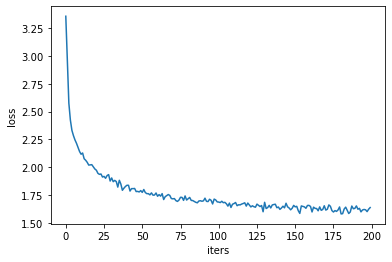

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

We is I aboan compalter;
Fare if the count from to yo?

KING RO:
Come, hanther such to hapm known dead Iffow or my heard you
For fourser;
In past hip a glist
and not be alaid unfull being to think as tree 'eld?

QUEEN OLUGLY:
I would wemphy as I pronce as he bahom the wagrand
Uo Ere thy hangght
of Parear
To other me.

LADY BONTA:
I will coustakn
Do you charge of my consuph
I can is verford, and, if I to to
For my shall you, lord.

BrONDOND:
To thee, very concime, but stortty Most
Did be it were be readrow'd,
Thy naturn your nomen, Not a quir passond, saint blong and be weept whon my, my blood q
